In [64]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
import datetime

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Cargamos la data 

El dataset Fashion-MNIST cotiene 60,00 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

In [3]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

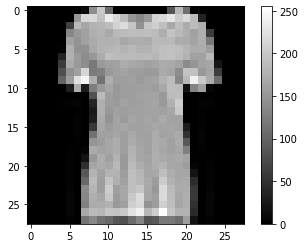

In [21]:
plt.imshow(train_images[10], cmap = 'gray')
plt.colorbar()

## Labels

In [5]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

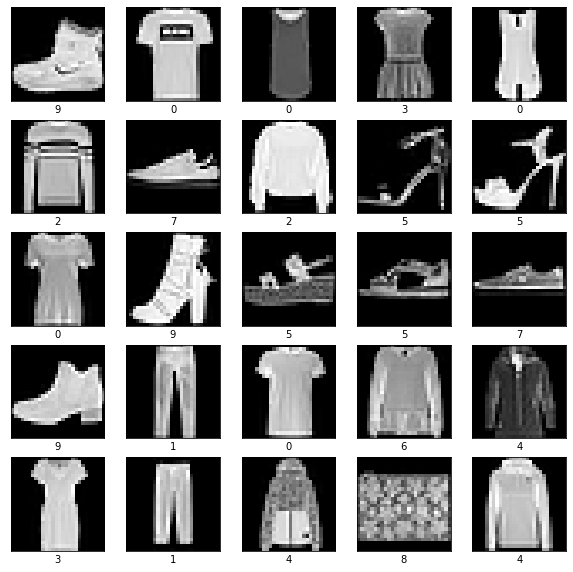

In [6]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard (agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

# Logistic Regression with Softmax

## Data cleaning and preprocessing

In [43]:
label_dictionary = {0:"T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

In [44]:
label_dictionary

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

#### One hot encoding of labels

In [9]:
# First we one hot encode the labels for our training set

enc_train = OneHotEncoder(categories='auto')
enc_train.fit(train_labels.reshape(-1, 1))
onehotlabels_train = enc_train.transform(train_labels.reshape(-1,1)).toarray()

print("train shape:", onehotlabels_train.shape)

# We one hot encode the labels for our test set

enc_test = OneHotEncoder(categories='auto')
enc_test.fit(test_labels.reshape(-1, 1))
onehotlabels_test = enc_test.transform(test_labels.reshape(-1,1)).toarray()

print("test shape:", onehotlabels_test.shape)

train shape: (60000, 10)
test shape: (10000, 10)


#### Image proprocessing

Se generan un set de datos de entrenamiento con datos crudos, con datos transformados aplicando normalizados y escalados.

In [10]:
def image_processing(images):

    # We transform our training images into row vectors
    tensor = images.reshape(-1, 28 * 28)
    # Add bias
    tensor = np.insert(tensor, 0, np.ones(len(tensor)), axis=1).astype(np.float32)
    print(tensor.shape)
    return tensor

In [11]:
x_train = image_processing(train_images)
x_test = image_processing(test_images)

(60000, 785)
(10000, 785)


In [12]:
def image_processing_normalized(images):

    # We transform our training images into row vectors
    tensor = images.reshape(-1, 28 * 28)
    # Normalize image
    tensor = normalize(tensor, norm = "max", axis = 1)
    # Add bias
    tensor = np.insert(tensor, 0, np.ones(len(tensor)), axis=1).astype(np.float32)
    print(tensor.shape)
    return tensor


In [13]:
x_train_normalized = image_processing_normalized(train_images)
x_test_normalized = image_processing_normalized(test_images)

(60000, 785)
(10000, 785)


In [14]:
def image_processing_scaled(images):

    # We transform our training images into row vectors
    tensor = images.reshape(-1, 28 * 28)
    # Normalize image
    tensor = scale(tensor)
    # Add bias
    tensor = np.insert(tensor, 0, np.ones(len(tensor)), axis=1).astype(np.float32)
    print(tensor.shape)
    return tensor


In [15]:
x_train_scaled = image_processing_scaled(train_images)
x_test_scaled = image_processing_scaled(test_images)

(60000, 785)
(10000, 785)


## Logistic regression model:

Se prepara una clase base para el modelo de regresión logística con softmax para la generación de una distribución de probabilidad:

In [46]:
class LogisticRegressionSoftmax:
    def __init__(self, x, labels):
        # vector de weights para logits
        self.w = tf.get_variable("weights", dtype = tf.float32, shape = [x_train.shape[1], labels.shape[1]], initializer = tf.zeros_initializer())
        
    # Funcion para el calculo de logits
    def logits(self, x):
        #with tf.name_scope("logits"):
        return tf.matmul(x, self.w)
    
    def prediction(self, x):
        #Method to produce probability distribution for output
        return tf.nn.softmax(self.logits(x))
    
    def accuracy(self, predictions, labels):
        #Accuracy calculation
        accuracy = tf.equal(tf.argmax(predictions,1), tf.argmax(labels,1))
        accuracy = tf.dtypes.cast(accuracy, tf.int32)
        accuracy = tf.divide(tf.reduce_sum(accuracy), tf.shape(labels)[0])
        return accuracy
            
    def update(self, x_train, labels_train, x_test, labels_test, learningrate):
        with tf.name_scope("error"):
            train_error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = labels_train, logits = self.logits(x_train)))
            train_error_summary = tf.summary.scalar("TrainError", train_error)
            test_error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = labels_test, logits = self.logits(x_test)))
            test_error_summary = tf.summary.scalar("TestError", test_error)
        with tf.name_scope("accuracy"):
            train_accuracy = self.accuracy(self.prediction(x_train), labels_train)
            train_accuracy_summary = tf.summary.scalar("TrainAccuracy", train_accuracy)
            test_accuracy = self.accuracy(self.prediction(x_test), labels_test)
            test_accuracy_summary = tf.summary.scalar("TestAccuracy", test_accuracy)
        # update parameters via gradient descent
        gradient = tf.gradients(train_error, [self.w])
        updated_w = tf.assign(self.w, self.w - learningrate * gradient[0])
        return updated_w, train_error, test_error, train_accuracy, test_accuracy, train_error_summary, test_error_summary, train_accuracy_summary, test_accuracy_summary
    

In [60]:
def training(lr, epochs, frecprint, x_train, x_test, labels_train, labels_test):
    # String para definicion de experimento
    string = './graphs/'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S") +"_lr="+str(lr)+ "_epochs="+str(epochs)

    g = tf.Graph()
    with g.as_default():
        # Inicialización de objeto de clase LogisticRegressionSoftmax
        modelo = LogisticRegressionSoftmax(x_train, onehotlabels_train)
        # Definicion de placeholders para input de data a grafo
        with tf.name_scope("train_tensors"):
            tensor_x_train = tf.placeholder(tf.float32, [None,x_train.shape[1]], "tensor_x_train")
            tensor_labels_train = tf.placeholder(tf.float32, [None,labels_train.shape[1]], "tensor_labels_train")
        with tf.name_scope("test_tensors"):
            tensor_x_test = tf.placeholder(tf.float32, [x_test.shape[0], x_test.shape[1]], "tensor_x_test")
            tensor_labels_test = tf.placeholder(tf.float32, [labels_test.shape[0], labels_test.shape[1]], "tensor_labels_test")
        # Utilizacion de método update para hacer el entrenamiento
        update_parameters = modelo.update(tensor_x_train, tensor_labels_train, tensor_x_test, tensor_labels_test, lr)
    
        # Writer para utilizacion de tensorboard
        writer = tf.summary.FileWriter(string, g)
        
        batch_size = 32
        
        total_steps = int((labels_train.shape[0] / batch_size) * epochs)  
        
        with tf.train.MonitoredSession() as session:
            
            for i in range(total_steps + 1):
                # Mini batch gradient descent with batch size 32
                offset = (i * batch_size) % (labels_train.shape[0] - batch_size)
                batch_data = x_train[offset:(offset + batch_size),]
                batch_labels = labels_train[offset:(offset + batch_size),]
                feed_dict = {tensor_x_train:batch_data, tensor_labels_train:batch_labels,tensor_x_test:x_test, tensor_labels_test:labels_test}
                # Entrenamiento
                training = session.run(update_parameters, feed_dict = feed_dict)
                if (i)%frecprint == 0:
                    # Cálculo de pesos para print por cada frecprint epocas
                    weights = session.run(modelo.w, feed_dict = feed_dict)
                    # Agregar datos a writer para poder visualizarlos en tensorboard
                    writer.add_summary(training[5], i)
                    writer.add_summary(training[6], i)
                    writer.add_summary(training[7], i)
                    writer.add_summary(training[8], i)
                    print("Mini-batch:", i, "train error:", training[1], "train accuracy:", training[3])
                    print("Epoch:", int(i//(labels_train.shape[0] / batch_size)+1), "test error:", training[2], "test accuracy:", training[4])
                    print("-------------------------------------------------------------------------")
            
            return weights

            writer.close()

### Graph

El grafo utilizado para todos los modelos de entrenamiento es el siguiente:

<img src= "graph.png">

### Experimentos de entrenamiento

In [24]:
weights = training(0.1, 5, 100, x_train, x_test, onehotlabels_train, onehotlabels_test)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Mini-batch: 0 train error: 2.3025854 train accuracy: 0.1875
Epoch: 1 test error: 2.3026016 test accuracy: 0.1
-------------------------------------------------------------------------
Mini-batch: 100 train error: 25536.52 train accuracy: 0.6875
Epoch: 1 test error: 18176.352 test accuracy: 0.6542
-------------------------------------------------------------------------
Mini-batch: 200 train error: 10021.326 train accuracy: 0.8125
Epoch: 1 test error: 10290.253 test accuracy: 0.7764
-------------------------------------------------------------------------
Mini-batch: 300 train error: 44967

Mini-batch: 3900 train error: 6028.2075 train accuracy: 0.8125
Epoch: 3 test error: 12131.67 test accuracy: 0.8107
-------------------------------------------------------------------------
Mini-batch: 4000 train error: 16304.623 train accuracy: 0.75
Epoch: 3 test error: 18884.084 test accuracy: 0.7202
-------------------------------------------------------------------------
Mini-batch: 4100 train error: 9833.801 train accuracy: 0.84375
Epoch: 3 test error: 16108.88 test accuracy: 0.7723
-------------------------------------------------------------------------
Mini-batch: 4200 train error: 36621.477 train accuracy: 0.8125
Epoch: 3 test error: 32116.154 test accuracy: 0.7674
-------------------------------------------------------------------------
Mini-batch: 4300 train error: 56535.42 train accuracy: 0.625
Epoch: 3 test error: 57716.8 test accuracy: 0.5703
-------------------------------------------------------------------------
Mini-batch: 4400 train error: 21533.121 train accuracy: 0.

Mini-batch: 8300 train error: 13542.594 train accuracy: 0.71875
Epoch: 5 test error: 24312.96 test accuracy: 0.7259
-------------------------------------------------------------------------
Mini-batch: 8400 train error: 2407.194 train accuracy: 0.90625
Epoch: 5 test error: 11131.331 test accuracy: 0.809
-------------------------------------------------------------------------
Mini-batch: 8500 train error: 20708.719 train accuracy: 0.75
Epoch: 5 test error: 59866.816 test accuracy: 0.7004
-------------------------------------------------------------------------
Mini-batch: 8600 train error: 3411.9116 train accuracy: 0.90625
Epoch: 5 test error: 9641.326 test accuracy: 0.8131
-------------------------------------------------------------------------
Mini-batch: 8700 train error: 6475.918 train accuracy: 0.84375
Epoch: 5 test error: 15247.622 test accuracy: 0.7609
-------------------------------------------------------------------------
Mini-batch: 8800 train error: 20047.246 train accurac

In [38]:
weights_normal = training(0.1, 5, 100, x_train_normalized, x_test_normalized, onehotlabels_train, onehotlabels_test)

Mini-batch: 0 train error: 2.3025854 train accuracy: 0.1875
Epoch: 1 test error: 2.2480607 test accuracy: 0.131
-------------------------------------------------------------------------
Mini-batch: 100 train error: 0.9082099 train accuracy: 0.6875
Epoch: 1 test error: 0.78719616 test accuracy: 0.7194
-------------------------------------------------------------------------
Mini-batch: 200 train error: 0.5704254 train accuracy: 0.8125
Epoch: 1 test error: 0.6700407 test accuracy: 0.7632
-------------------------------------------------------------------------
Mini-batch: 300 train error: 0.9378215 train accuracy: 0.65625
Epoch: 1 test error: 0.7751994 test accuracy: 0.7339
-------------------------------------------------------------------------
Mini-batch: 400 train error: 0.50744164 train accuracy: 0.90625
Epoch: 1 test error: 0.6265196 test accuracy: 0.7792
-------------------------------------------------------------------------
Mini-batch: 500 train error: 0.8718115 train accuracy:

Mini-batch: 4300 train error: 0.8514012 train accuracy: 0.75
Epoch: 3 test error: 0.5258145 test accuracy: 0.8175
-------------------------------------------------------------------------
Mini-batch: 4400 train error: 0.3269229 train accuracy: 0.90625
Epoch: 3 test error: 0.47289044 test accuracy: 0.8359
-------------------------------------------------------------------------
Mini-batch: 4500 train error: 0.5289998 train accuracy: 0.84375
Epoch: 3 test error: 0.51294225 test accuracy: 0.8269
-------------------------------------------------------------------------
Mini-batch: 4600 train error: 0.333341 train accuracy: 0.90625
Epoch: 3 test error: 0.49182174 test accuracy: 0.8329
-------------------------------------------------------------------------
Mini-batch: 4700 train error: 0.24602896 train accuracy: 0.90625
Epoch: 3 test error: 0.48026377 test accuracy: 0.8314
-------------------------------------------------------------------------
Mini-batch: 4800 train error: 0.37774235 tra

Mini-batch: 8600 train error: 0.28789514 train accuracy: 0.90625
Epoch: 5 test error: 0.47560957 test accuracy: 0.8357
-------------------------------------------------------------------------
Mini-batch: 8700 train error: 0.36303672 train accuracy: 0.84375
Epoch: 5 test error: 0.46986654 test accuracy: 0.8365
-------------------------------------------------------------------------
Mini-batch: 8800 train error: 0.38988197 train accuracy: 0.78125
Epoch: 5 test error: 0.5448006 test accuracy: 0.8086
-------------------------------------------------------------------------
Mini-batch: 8900 train error: 0.8754306 train accuracy: 0.6875
Epoch: 5 test error: 0.50595266 test accuracy: 0.8258
-------------------------------------------------------------------------
Mini-batch: 9000 train error: 0.54628253 train accuracy: 0.78125
Epoch: 5 test error: 0.469096 test accuracy: 0.8383
-------------------------------------------------------------------------
Mini-batch: 9100 train error: 0.36669585

In [36]:
weights_scaled = training(0.1, 5, 100, x_train_scaled, x_test_scaled, onehotlabels_train, onehotlabels_test)

Mini-batch: 0 train error: 2.3025854 train accuracy: 0.1875
Epoch: 1 test error: 1.6534549 test accuracy: 0.3965
-------------------------------------------------------------------------
Mini-batch: 100 train error: 0.851563 train accuracy: 0.71875
Epoch: 1 test error: 0.6962517 test accuracy: 0.7841
-------------------------------------------------------------------------
Mini-batch: 200 train error: 0.43338078 train accuracy: 0.84375
Epoch: 1 test error: 0.7037204 test accuracy: 0.8004
-------------------------------------------------------------------------
Mini-batch: 300 train error: 0.81474894 train accuracy: 0.78125
Epoch: 1 test error: 0.8436494 test accuracy: 0.7597
-------------------------------------------------------------------------
Mini-batch: 400 train error: 0.5167681 train accuracy: 0.8125
Epoch: 1 test error: 0.7729296 test accuracy: 0.763
-------------------------------------------------------------------------
Mini-batch: 500 train error: 1.1434814 train accuracy:

Mini-batch: 4400 train error: 0.32399303 train accuracy: 0.8125
Epoch: 3 test error: 0.6749788 test accuracy: 0.8094
-------------------------------------------------------------------------
Mini-batch: 4500 train error: 0.5263186 train accuracy: 0.78125
Epoch: 3 test error: 0.6094054 test accuracy: 0.8229
-------------------------------------------------------------------------
Mini-batch: 4600 train error: 0.31286955 train accuracy: 0.90625
Epoch: 3 test error: 0.62213475 test accuracy: 0.8192
-------------------------------------------------------------------------
Mini-batch: 4700 train error: 0.28119987 train accuracy: 0.90625
Epoch: 3 test error: 0.64343894 test accuracy: 0.8126
-------------------------------------------------------------------------
Mini-batch: 4800 train error: 0.67329085 train accuracy: 0.8125
Epoch: 3 test error: 0.67861813 test accuracy: 0.8096
-------------------------------------------------------------------------
Mini-batch: 4900 train error: 0.65797913

Mini-batch: 8700 train error: 0.3664001 train accuracy: 0.875
Epoch: 5 test error: 0.6600837 test accuracy: 0.812
-------------------------------------------------------------------------
Mini-batch: 8800 train error: 0.40232462 train accuracy: 0.84375
Epoch: 5 test error: 0.67048633 test accuracy: 0.8176
-------------------------------------------------------------------------
Mini-batch: 8900 train error: 1.2816484 train accuracy: 0.6875
Epoch: 5 test error: 0.63180727 test accuracy: 0.817
-------------------------------------------------------------------------
Mini-batch: 9000 train error: 0.4217943 train accuracy: 0.8125
Epoch: 5 test error: 0.7438707 test accuracy: 0.7991
-------------------------------------------------------------------------
Mini-batch: 9100 train error: 0.4541527 train accuracy: 0.84375
Epoch: 5 test error: 0.65395486 test accuracy: 0.8195
-------------------------------------------------------------------------
Mini-batch: 9200 train error: 1.0350866 train a

In [61]:
weights_normal = training(0.1, 10, 100, x_train_normalized, x_test_normalized, onehotlabels_train, onehotlabels_test)

Mini-batch: 0 train error: 2.3025854 train accuracy: 0.1875
Epoch: 1 test error: 2.2519398 test accuracy: 0.1213
-------------------------------------------------------------------------
Mini-batch: 100 train error: 0.9082099 train accuracy: 0.6875
Epoch: 1 test error: 0.7704702 test accuracy: 0.7235
-------------------------------------------------------------------------
Mini-batch: 200 train error: 0.5704254 train accuracy: 0.8125
Epoch: 1 test error: 0.6700407 test accuracy: 0.7632
-------------------------------------------------------------------------
Mini-batch: 300 train error: 0.9378215 train accuracy: 0.65625
Epoch: 1 test error: 0.7802065 test accuracy: 0.7337
-------------------------------------------------------------------------
Mini-batch: 400 train error: 0.50744164 train accuracy: 0.90625
Epoch: 1 test error: 0.6596732 test accuracy: 0.7673
-------------------------------------------------------------------------
Mini-batch: 500 train error: 0.8718115 train accuracy:

Mini-batch: 4300 train error: 0.8514012 train accuracy: 0.75
Epoch: 3 test error: 0.80276394 test accuracy: 0.7217
-------------------------------------------------------------------------
Mini-batch: 4400 train error: 0.3269229 train accuracy: 0.90625
Epoch: 3 test error: 0.474208 test accuracy: 0.8361000000000001
-------------------------------------------------------------------------
Mini-batch: 4500 train error: 0.5289998 train accuracy: 0.84375
Epoch: 3 test error: 0.51294225 test accuracy: 0.8269000000000001
-------------------------------------------------------------------------
Mini-batch: 4600 train error: 0.333341 train accuracy: 0.90625
Epoch: 3 test error: 0.4659019 test accuracy: 0.8399000000000001
-------------------------------------------------------------------------
Mini-batch: 4700 train error: 0.24602896 train accuracy: 0.90625
Epoch: 3 test error: 0.47383758 test accuracy: 0.8352
-------------------------------------------------------------------------
Mini-batch

Mini-batch: 8600 train error: 0.28789514 train accuracy: 0.90625
Epoch: 5 test error: 0.4836922 test accuracy: 0.8343
-------------------------------------------------------------------------
Mini-batch: 8700 train error: 0.36303672 train accuracy: 0.84375
Epoch: 5 test error: 0.46986654 test accuracy: 0.8365
-------------------------------------------------------------------------
Mini-batch: 8800 train error: 0.38988197 train accuracy: 0.78125
Epoch: 5 test error: 0.5448006 test accuracy: 0.8086
-------------------------------------------------------------------------
Mini-batch: 8900 train error: 0.8754306 train accuracy: 0.6875
Epoch: 5 test error: 0.5061451 test accuracy: 0.8256
-------------------------------------------------------------------------
Mini-batch: 9000 train error: 0.54628253 train accuracy: 0.78125
Epoch: 5 test error: 0.45864424 test accuracy: 0.8391000000000001
-------------------------------------------------------------------------
Mini-batch: 9100 train error

Mini-batch: 12800 train error: 0.20574048 train accuracy: 0.90625
Epoch: 7 test error: 0.45306242 test accuracy: 0.8437
-------------------------------------------------------------------------
Mini-batch: 12900 train error: 0.49167106 train accuracy: 0.8125
Epoch: 7 test error: 0.45438555 test accuracy: 0.8433
-------------------------------------------------------------------------
Mini-batch: 13000 train error: 0.30873293 train accuracy: 0.875
Epoch: 7 test error: 0.46595907 test accuracy: 0.8342
-------------------------------------------------------------------------
Mini-batch: 13100 train error: 0.2256917 train accuracy: 0.90625
Epoch: 7 test error: 0.45654872 test accuracy: 0.8403
-------------------------------------------------------------------------
Mini-batch: 13200 train error: 0.3829836 train accuracy: 0.84375
Epoch: 8 test error: 0.48542422 test accuracy: 0.8272
-------------------------------------------------------------------------
Mini-batch: 13300 train error: 0.49

Mini-batch: 17000 train error: 0.33891493 train accuracy: 0.875
Epoch: 10 test error: 0.45434874 test accuracy: 0.8417
-------------------------------------------------------------------------
Mini-batch: 17100 train error: 0.4599603 train accuracy: 0.78125
Epoch: 10 test error: 0.48428077 test accuracy: 0.8293
-------------------------------------------------------------------------
Mini-batch: 17200 train error: 0.55306673 train accuracy: 0.84375
Epoch: 10 test error: 0.4620213 test accuracy: 0.8390000000000001
-------------------------------------------------------------------------
Mini-batch: 17300 train error: 0.50775707 train accuracy: 0.78125
Epoch: 10 test error: 0.5125826 test accuracy: 0.8215
-------------------------------------------------------------------------
Mini-batch: 17400 train error: 0.5023203 train accuracy: 0.84375
Epoch: 10 test error: 0.4637839 test accuracy: 0.8400000000000001
-------------------------------------------------------------------------
Mini-bat

In [62]:
weights_normal = training(0.01, 10, 100, x_train_normalized, x_test_normalized, onehotlabels_train, onehotlabels_test)

Mini-batch: 0 train error: 2.3025854 train accuracy: 0.1875
Epoch: 1 test error: 2.2816277 test accuracy: 0.1476
-------------------------------------------------------------------------
Mini-batch: 100 train error: 1.3515627 train accuracy: 0.59375
Epoch: 1 test error: 1.3250515 test accuracy: 0.6551
-------------------------------------------------------------------------
Mini-batch: 200 train error: 1.0781431 train accuracy: 0.625
Epoch: 1 test error: 1.0766509 test accuracy: 0.6625
-------------------------------------------------------------------------
Mini-batch: 300 train error: 1.0852971 train accuracy: 0.65625
Epoch: 1 test error: 0.966726 test accuracy: 0.6846
-------------------------------------------------------------------------
Mini-batch: 400 train error: 0.82372844 train accuracy: 0.71875
Epoch: 1 test error: 0.89643925 test accuracy: 0.7192000000000001
-------------------------------------------------------------------------
Mini-batch: 500 train error: 0.953192 trai

Mini-batch: 4300 train error: 0.58984065 train accuracy: 0.8125
Epoch: 3 test error: 0.5682934 test accuracy: 0.8102
-------------------------------------------------------------------------
Mini-batch: 4400 train error: 0.45453078 train accuracy: 0.84375
Epoch: 3 test error: 0.5695952 test accuracy: 0.8098000000000001
-------------------------------------------------------------------------
Mini-batch: 4500 train error: 0.5049322 train accuracy: 0.8125
Epoch: 3 test error: 0.5674155 test accuracy: 0.8109000000000001
-------------------------------------------------------------------------
Mini-batch: 4600 train error: 0.5126983 train accuracy: 0.875
Epoch: 3 test error: 0.561949 test accuracy: 0.8131
-------------------------------------------------------------------------
Mini-batch: 4700 train error: 0.35751945 train accuracy: 0.96875
Epoch: 3 test error: 0.5618255 test accuracy: 0.8118000000000001
-------------------------------------------------------------------------
Mini-batch:

Mini-batch: 8500 train error: 0.36176243 train accuracy: 0.875
Epoch: 5 test error: 0.52095306 test accuracy: 0.8239000000000001
-------------------------------------------------------------------------
Mini-batch: 8600 train error: 0.40576255 train accuracy: 0.875
Epoch: 5 test error: 0.5223671 test accuracy: 0.8233
-------------------------------------------------------------------------
Mini-batch: 8700 train error: 0.56013197 train accuracy: 0.78125
Epoch: 5 test error: 0.52019775 test accuracy: 0.8243
-------------------------------------------------------------------------
Mini-batch: 8800 train error: 0.33964357 train accuracy: 0.9375
Epoch: 5 test error: 0.52163696 test accuracy: 0.8245
-------------------------------------------------------------------------
Mini-batch: 8900 train error: 0.7319274 train accuracy: 0.75
Epoch: 5 test error: 0.5187913 test accuracy: 0.8258000000000001
-------------------------------------------------------------------------
Mini-batch: 9000 train

Mini-batch: 12700 train error: 0.59488237 train accuracy: 0.84375
Epoch: 7 test error: 0.50053406 test accuracy: 0.8291000000000001
-------------------------------------------------------------------------
Mini-batch: 12800 train error: 0.32589117 train accuracy: 0.90625
Epoch: 7 test error: 0.50117064 test accuracy: 0.8295
-------------------------------------------------------------------------
Mini-batch: 12900 train error: 0.6279452 train accuracy: 0.71875
Epoch: 7 test error: 0.5024029 test accuracy: 0.8262
-------------------------------------------------------------------------
Mini-batch: 13000 train error: 0.35407525 train accuracy: 0.875
Epoch: 7 test error: 0.49956694 test accuracy: 0.8307
-------------------------------------------------------------------------
Mini-batch: 13100 train error: 0.27373976 train accuracy: 0.90625
Epoch: 7 test error: 0.5007724 test accuracy: 0.8295
-------------------------------------------------------------------------
Mini-batch: 13200 train

Mini-batch: 16900 train error: 0.58212775 train accuracy: 0.78125
Epoch: 10 test error: 0.48916456 test accuracy: 0.8311000000000001
-------------------------------------------------------------------------
Mini-batch: 17000 train error: 0.40814272 train accuracy: 0.84375
Epoch: 10 test error: 0.4901002 test accuracy: 0.8305
-------------------------------------------------------------------------
Mini-batch: 17100 train error: 0.47004136 train accuracy: 0.8125
Epoch: 10 test error: 0.49136803 test accuracy: 0.8281000000000001
-------------------------------------------------------------------------
Mini-batch: 17200 train error: 0.5897801 train accuracy: 0.71875
Epoch: 10 test error: 0.48814073 test accuracy: 0.8307
-------------------------------------------------------------------------
Mini-batch: 17300 train error: 0.50072205 train accuracy: 0.84375
Epoch: 10 test error: 0.48772696 test accuracy: 0.8328
-------------------------------------------------------------------------
Mini

In [63]:
weights_normal = training(0.01, 15, 100, x_train_normalized, x_test_normalized, onehotlabels_train, onehotlabels_test)

Mini-batch: 0 train error: 2.3025854 train accuracy: 0.1875
Epoch: 1 test error: 2.3022888 test accuracy: 0.10360000000000001
-------------------------------------------------------------------------
Mini-batch: 100 train error: 1.3515627 train accuracy: 0.59375
Epoch: 1 test error: 1.3250515 test accuracy: 0.6551
-------------------------------------------------------------------------
Mini-batch: 200 train error: 1.0781431 train accuracy: 0.625
Epoch: 1 test error: 1.0766509 test accuracy: 0.6625
-------------------------------------------------------------------------
Mini-batch: 300 train error: 1.0852971 train accuracy: 0.65625
Epoch: 1 test error: 0.9624125 test accuracy: 0.6861
-------------------------------------------------------------------------
Mini-batch: 400 train error: 0.82372844 train accuracy: 0.71875
Epoch: 1 test error: 0.89642704 test accuracy: 0.7192000000000001
-------------------------------------------------------------------------
Mini-batch: 500 train error:

Mini-batch: 4300 train error: 0.58984065 train accuracy: 0.8125
Epoch: 3 test error: 0.56748503 test accuracy: 0.8108000000000001
-------------------------------------------------------------------------
Mini-batch: 4400 train error: 0.45453078 train accuracy: 0.84375
Epoch: 3 test error: 0.5695239 test accuracy: 0.8095
-------------------------------------------------------------------------
Mini-batch: 4500 train error: 0.5049322 train accuracy: 0.8125
Epoch: 3 test error: 0.56696945 test accuracy: 0.8105
-------------------------------------------------------------------------
Mini-batch: 4600 train error: 0.5126983 train accuracy: 0.875
Epoch: 3 test error: 0.56193465 test accuracy: 0.8131
-------------------------------------------------------------------------
Mini-batch: 4700 train error: 0.35751945 train accuracy: 0.96875
Epoch: 3 test error: 0.5618255 test accuracy: 0.8118000000000001
-------------------------------------------------------------------------
Mini-batch: 4800 tr

Mini-batch: 8500 train error: 0.36176243 train accuracy: 0.875
Epoch: 5 test error: 0.52095306 test accuracy: 0.8239000000000001
-------------------------------------------------------------------------
Mini-batch: 8600 train error: 0.40576255 train accuracy: 0.875
Epoch: 5 test error: 0.5223671 test accuracy: 0.8233
-------------------------------------------------------------------------
Mini-batch: 8700 train error: 0.56013197 train accuracy: 0.78125
Epoch: 5 test error: 0.51973176 test accuracy: 0.8256
-------------------------------------------------------------------------
Mini-batch: 8800 train error: 0.33964357 train accuracy: 0.9375
Epoch: 5 test error: 0.5221111 test accuracy: 0.8234
-------------------------------------------------------------------------
Mini-batch: 8900 train error: 0.7319274 train accuracy: 0.75
Epoch: 5 test error: 0.5187913 test accuracy: 0.8258000000000001
-------------------------------------------------------------------------
Mini-batch: 9000 train 

Mini-batch: 12700 train error: 0.59488237 train accuracy: 0.84375
Epoch: 7 test error: 0.50053406 test accuracy: 0.8291000000000001
-------------------------------------------------------------------------
Mini-batch: 12800 train error: 0.32589117 train accuracy: 0.90625
Epoch: 7 test error: 0.50117064 test accuracy: 0.8295
-------------------------------------------------------------------------
Mini-batch: 12900 train error: 0.6279452 train accuracy: 0.71875
Epoch: 7 test error: 0.5023824 test accuracy: 0.8264
-------------------------------------------------------------------------
Mini-batch: 13000 train error: 0.35407525 train accuracy: 0.875
Epoch: 7 test error: 0.49956694 test accuracy: 0.8307
-------------------------------------------------------------------------
Mini-batch: 13100 train error: 0.27373976 train accuracy: 0.90625
Epoch: 7 test error: 0.50088245 test accuracy: 0.8295
-------------------------------------------------------------------------
Mini-batch: 13200 trai

Mini-batch: 16900 train error: 0.58212775 train accuracy: 0.78125
Epoch: 10 test error: 0.48969185 test accuracy: 0.8298000000000001
-------------------------------------------------------------------------
Mini-batch: 17000 train error: 0.40814272 train accuracy: 0.84375
Epoch: 10 test error: 0.49052685 test accuracy: 0.8297
-------------------------------------------------------------------------
Mini-batch: 17100 train error: 0.47004136 train accuracy: 0.8125
Epoch: 10 test error: 0.49119845 test accuracy: 0.8285
-------------------------------------------------------------------------
Mini-batch: 17200 train error: 0.5897801 train accuracy: 0.71875
Epoch: 10 test error: 0.48814398 test accuracy: 0.8307
-------------------------------------------------------------------------
Mini-batch: 17300 train error: 0.50072205 train accuracy: 0.84375
Epoch: 10 test error: 0.49051464 test accuracy: 0.8298000000000001
-------------------------------------------------------------------------
Min

Mini-batch: 21100 train error: 0.5032534 train accuracy: 0.84375
Epoch: 12 test error: 0.4794248 test accuracy: 0.8321000000000001
-------------------------------------------------------------------------
Mini-batch: 21200 train error: 0.39403325 train accuracy: 0.75
Epoch: 12 test error: 0.48014438 test accuracy: 0.8325
-------------------------------------------------------------------------
Mini-batch: 21300 train error: 0.4442709 train accuracy: 0.8125
Epoch: 12 test error: 0.4796645 test accuracy: 0.8345
-------------------------------------------------------------------------
Mini-batch: 21400 train error: 0.28530878 train accuracy: 0.9375
Epoch: 12 test error: 0.4849791 test accuracy: 0.8329000000000001
-------------------------------------------------------------------------
Mini-batch: 21500 train error: 0.42685932 train accuracy: 0.8125
Epoch: 12 test error: 0.48426256 test accuracy: 0.8280000000000001
-------------------------------------------------------------------------


Mini-batch: 25300 train error: 0.5397328 train accuracy: 0.78125
Epoch: 14 test error: 0.47233525 test accuracy: 0.8353
-------------------------------------------------------------------------
Mini-batch: 25400 train error: 0.46252596 train accuracy: 0.90625
Epoch: 14 test error: 0.47337627 test accuracy: 0.8354
-------------------------------------------------------------------------
Mini-batch: 25500 train error: 0.43498194 train accuracy: 0.875
Epoch: 14 test error: 0.47302574 test accuracy: 0.8365
-------------------------------------------------------------------------
Mini-batch: 25600 train error: 0.41049835 train accuracy: 0.875
Epoch: 14 test error: 0.47543335 test accuracy: 0.8356
-------------------------------------------------------------------------
Mini-batch: 25700 train error: 0.37157738 train accuracy: 0.875
Epoch: 14 test error: 0.4738146 test accuracy: 0.8352
-------------------------------------------------------------------------
Mini-batch: 25800 train error: 0.

#### Experimentos:

En la siguiente imagen se puede observar los distintos experimentos llevados a cabo para comprobar la efectividad de utilizar datos escalados y datos normalizados para mejorar el rendimiento del modelo de regresión logística. 

* Anaranjado : datos crudos por 5 épocas
* Azul: datos normalizados por 5 épocas
* Verde: datos normalizados por 10 épocas
* Rojo: datos escalados por 5 épocas

<img src="training.png">

Observando estos datos de entrenamiento se puede observar que el entrenamiento realizado con los datos normalizados si genera un modelo con mejor rendimiento, tanto en disminución del error, así como en la accuracy medida en el train y test set. La ganancia obtenida por el entrenamiento por 10 épocas de los datos normalizados no parece ser significativa en comparación con el entrenamiento con 5 época, obteniendo al final una accuracy muy parecida. Sin embargo, en el gráfico se observa en las gráficas *smoothed*, que la tendencia en general por las 5 épocas más si genera resultados levemente mejores.

#### Experimentos posteriores:

Observando el comportamiento estocástico al utilizar un learning rate de 0.1, se decidió repetir los experimentos con un learning rate de 0.01, habiéndose obtenido resultados mejores con un modelo entrenado por 15 épocas con 0.01, y con datos normalizados.

<img src=training2.png>

En los gráficos anteriores, el modelo mencionado que fue entrenado con un lr de 0.01 representa la línea azul de accuracy y de error que no muestra un comportamiento estocástico tan marcado. Se prefiere este modelo por esto mismo.

## Predicciones con modelo escogido

In [52]:
def prediction(tensor_x, img_num, weights):
    tf.logging.set_verbosity(tf.logging.ERROR)
    tf.reset_default_graph()
    tensor_x = tensor_x[img_num]
    tensor_x = tensor_x.reshape(1, 785)
    prediction = tf.get_variable("prediction", dtype = tf.int32, shape = [],initializer = tf.zeros_initializer())
    tensor_x_test = tf.placeholder(tf.float32, [tensor_x.shape[0], tensor_x.shape[1]], "tensor_x_test")
    tensor_w_test = tf.placeholder(tf.float32, [weights.shape[0], weights.shape[1]], "tensor_w_test")
    prediction_softmax = tf.argmax(tf.nn.softmax(tf.matmul(tensor_x_test, tensor_w_test)),1)
    
    with tf.train.MonitoredSession() as session:
                                 
        feed_dict = {tensor_x_test:tensor_x, tensor_w_test: weights}
        predicted_label = session.run(prediction_softmax, feed_dict = feed_dict)
        label_dictionary.get(int(predicted_label))
        plt.imshow(test_images[img_num], cmap = 'gray')
        plt.title(label_dictionary.get(int(predicted_label)))
        plt.xticks([])
        plt.yticks([])
        plt.show()
    

### Pruebas de modelo con imágenes del set de test

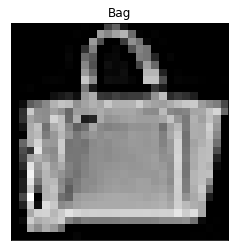

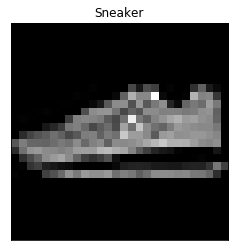

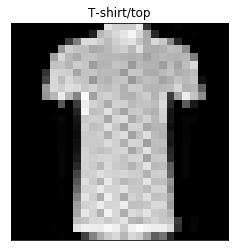

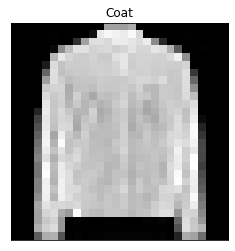

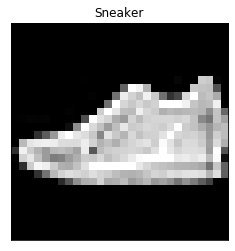

In [57]:
from random import sample 

indices = list(np.linspace(0,len(x_test), len(x_test), dtype=np.int32))

for i in sample(indices,5):
    prediction(x_test_normalized, i, weights_normal)

In [34]:
%tensorboard --logdir ./graphs --port 6006

Reusing TensorBoard on port 6006 (pid 16592), started 0:01:59 ago. (Use '!kill 16592' to kill it.)

# Conclusiones

* Se observó que los datos normalizados dieron en términos generales, mejores resultados que los datos escalados o los datos crudos. Esto podría deberse a la estabilidad numérica dada por datos en general más pequeños, al momento de calcular gradientes.
* Mini-batch gradient descent permite obtener resultados semejantes a utilizar el dataset de entrenamiento completo para hacer gradient descent, con una tendencia en general de disminución del error y aumento del accuracy del modelo.
* El modelo que se escogió (entrenado por 15 epochs y con un learning rate de 0.01) para hacer las predicciones alcanzó un accuracy de aproximadamente el 84% en la predicción de las 10 clases de diferentes de prendas de ropa.
* Aumentar el capacity del modelo por medio de generar un multi-layer perceptron podría mejorar el rendimiento al aumentar la cantidad de posibles parámetros a optimizar.
